# Problema 2 - Utilizar RNN e LSTM para prever se uma critica é positiva ou negativa

In [22]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("TensorFlow version:", tf.__version__)

mixed_precision.set_global_policy('mixed_float16')

Num GPUs Available:  1
Num CPUs Available:  1
TensorFlow version: 2.20.0


In [2]:
import pandas as pd

df = pd.read_csv('./dataset/rotten_tomatoes_movie_reviews.csv')

In [3]:
df.head()

,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,http://www.dreadcentral.com/index.php?name=Rev...
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,https://www.cbr.com/city-hunter-shinjuku-priva...
3,city_hunter_shinjuku_private_eyes,2558908,2019-02-14,Matt Schley,False,2.5/5,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,https://www.japantimes.co.jp/culture/2019/02/0...
4,dangerous_men_2015,2504681,2018-08-29,Pat Padua,False,NaN,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,http://dcist.com/2015/11/out_of_frame_dangerou...


In [4]:
df.info()

print("\nValores únicos em scoreSentiment:")
count_values = df['scoreSentiment'].value_counts()
percentages = df['scoreSentiment'].value_counts(normalize=True) * 100


pd.DataFrame({
    'Count': count_values,
    'Percentage': percentages.round(2).astype(str) + '%'
})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444963 entries, 0 to 1444962
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   id              1444963 non-null  object
 1   reviewId        1444963 non-null  int64 
 2   creationDate    1444963 non-null  object
 3   criticName      1444963 non-null  object
 4   isTopCritic     1444963 non-null  bool  
 5   originalScore   1009745 non-null  object
 6   reviewState     1444963 non-null  object
 7   publicatioName  1444963 non-null  object
 8   reviewText      1375738 non-null  object
 9   scoreSentiment  1444963 non-null  object
 10  reviewUrl       1234038 non-null  object
dtypes: bool(1), int64(1), object(9)
memory usage: 111.6+ MB

Valores únicos em scoreSentiment:


,Count,Percentage
scoreSentiment,,
POSITIVE,963799,66.7%
NEGATIVE,481164,33.3%


In [5]:
df['scoreSentimentBinary'] = df['scoreSentiment'].map({'POSITIVE': 1, 'NEGATIVE': 0})

df[['scoreSentiment', 'scoreSentimentBinary']].head()

,scoreSentiment,scoreSentimentBinary
0,POSITIVE,1
1,NEGATIVE,0
2,POSITIVE,1
3,NEGATIVE,0
4,POSITIVE,1


In [6]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['reviewText'], inplace=True)
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split()))

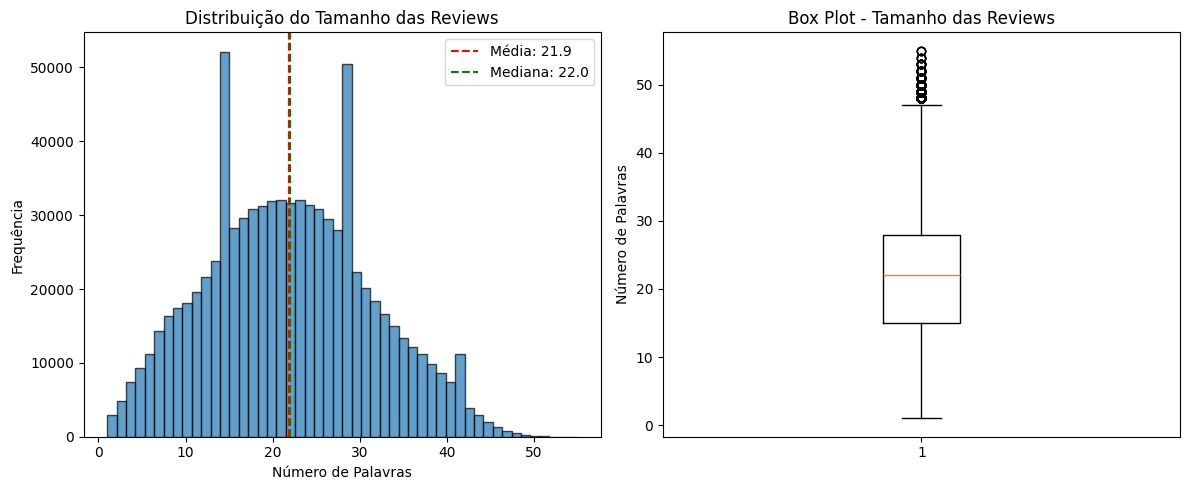

=== ESTATÍSTICAS DO TAMANHO DAS REVIEWS ===
Mínimo: 1 palavras
Máximo: 55 palavras
Média: 21.92 palavras
Mediana: 22.00 palavras
Desvio padrão: 9.45

=== PERCENTIS ===
25º percentil: 15 palavras (cobre 26.9% dos dados)
50º percentil: 22 palavras (cobre 53.3% dos dados)
75º percentil: 28 palavras (cobre 75.2% dos dados)
80º percentil: 30 palavras (cobre 80.9% dos dados)
90º percentil: 35 palavras (cobre 91.1% dos dados)
95º percentil: 38 palavras (cobre 95.2% dos dados)
99º percentil: 43 palavras (cobre 99.0% dos dados)


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Analisar distribuição de tamanhos das reviews
review_lengths = df['word_count']

plt.figure(figsize=(12, 5))

# Histograma
plt.subplot(1, 2, 1)
plt.hist(review_lengths, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.title('Distribuição do Tamanho das Reviews')
plt.axvline(review_lengths.mean(), color='red', linestyle='--', label=f'Média: {review_lengths.mean():.1f}')
plt.axvline(review_lengths.median(), color='green', linestyle='--', label=f'Mediana: {review_lengths.median():.1f}')
plt.legend()

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(review_lengths)
plt.ylabel('Número de Palavras')
plt.title('Box Plot - Tamanho das Reviews')

plt.tight_layout()
plt.show()

# Estatísticas descritivas
print("=== ESTATÍSTICAS DO TAMANHO DAS REVIEWS ===")
print(f"Mínimo: {review_lengths.min()} palavras")
print(f"Máximo: {review_lengths.max()} palavras")
print(f"Média: {review_lengths.mean():.2f} palavras")
print(f"Mediana: {review_lengths.median():.2f} palavras")
print(f"Desvio padrão: {review_lengths.std():.2f}")

# Percentis importantes
percentiles = [25, 50, 75, 80, 90, 95, 99]
print("\n=== PERCENTIS ===")
for p in percentiles:
    value = np.percentile(review_lengths, p)
    percentage_covered = (review_lengths <= value).mean() * 100
    print(f"{p}º percentil: {value:.0f} palavras (cobre {percentage_covered:.1f}% dos dados)")

In [8]:
from sklearn.model_selection import train_test_split

x = df['reviewText']
y = df['scoreSentimentBinary']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamanho do conjunto de treino: {len(x_train)}")
print(f"Tamanho do conjunto de teste: {len(x_test)}")

Tamanho do conjunto de treino: 652159
Tamanho do conjunto de teste: 163040


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional
import numpy as np

# Definir parâmetros
max_words = 10000  # Tamanho máximo do vocabulário
max_len = 43  # Comprimento máximo da sequência

# Criar e treinar o tokenizador
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

# Converter textos em sequências
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Preencher sequências para garantir comprimento uniforme
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post', truncating='post')

# Verificar a forma dos nossos dados
print(f"Training data shape: {x_train_pad.shape}")
print(f"Testing data shape: {x_test_pad.shape}")

Training data shape: (652159, 43)
Testing data shape: (163040, 43)


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Configurar callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',          # Métrica a monitorar
    patience=3,                  # Aguardar 3 épocas sem melhoria
    restore_best_weights=True,   # Restaurar os melhores pesos
    verbose=1                    # Mostrar quando parar
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Métrica a monitorar
    factor=0.5,                  # Reduzir LR pela metade
    patience=2,                  # Aguardar 2 épocas sem melhoria
    min_lr=1e-6,                 # LR mínimo
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

In [12]:
from tensorflow.keras.layers import SimpleRNN


# Construir modelo RNN para análise de sentimento
simple_RNN_model = Sequential([
    # Camada de Embedding para converter tokens em vetores de tamanho fixo
    Embedding(input_dim=max_words, output_dim=64),
    
    # Camada SimpleRNN 
    SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2),
    
    # Camada de saída com ativação sigmoid para classificação binária
    Dense(1, activation='sigmoid')
])

# Compilar o modelo
simple_RNN_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = simple_RNN_model.fit(x_train_pad, y_train, epochs=50, batch_size=64, validation_data=(x_test_pad, y_test), callbacks=callbacks, class_weight={0: 2, 1: 1})
simple_RNN_model.summary()

Epoch 1/50


I0000 00:00:1759667497.862527   27346 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5011 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9
2025-10-05 09:31:39.202092: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fafb0008220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-05 09:31:39.202108: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-10-05 09:31:39.249511: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-05 09:31:39.461057: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300
2025-10-05 09:31:39.551181: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All confi

   47/10190 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.5061 - loss: 0.9456  

I0000 00:00:1759667501.863185   27760 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10177/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5091 - loss: 0.9278

2025-10-05 09:32:14.038298: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 09:32:14.038321: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 09:32:14.038332: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 09:32:14.038342: I external/l

10190/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5091 - loss: 0.9278

2025-10-05 09:32:16.320822: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 09:32:16.780419: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14', 360 bytes spill stores, 360 bytes spill loads

2025-10-05 09:32:19.380992: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 09:32:19.845926: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

10190/10190 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.5106 - loss: 0.9255 - val_accuracy: 0.5598 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 2/50
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.5196 - loss: 0.9243 - val_accuracy: 0.5881 - val_loss: 0.6830 - learning_rate: 0.0010
Epoch 3/50
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.5217 - loss: 0.9237 - val_accuracy: 0.4805 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 4/50
10179/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5106 - loss: 0.9244
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.5122 - loss: 0.9243 - val_accuracy: 0.4381 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 5/50
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.5126 - loss: 0.9227 - val_accuracy: 0.3390 - val_loss: 0.6971 - learning_rate: 5.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 43, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,994,501 (7.61 MB)

 Trainable params: 664,833 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,329,668 (5.07 MB)

In [13]:
from tensorflow.keras.layers import LSTM

LSTM_model = Sequential([
    Embedding(input_dim=max_words, output_dim=64),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

# Compilar o modelo
LSTM_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = LSTM_model.fit(x_train_pad, y_train, epochs=50, batch_size=64, validation_data=(x_test_pad, y_test), callbacks=callbacks, class_weight={0: 2, 1: 1})
LSTM_model.summary()

Epoch 1/50
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 576s 56ms/step - accuracy: 0.7279 - loss: 0.6536 - val_accuracy: 0.8176 - val_loss: 0.3892 - learning_rate: 0.0010
Epoch 2/50
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 574s 56ms/step - accuracy: 0.8311 - loss: 0.4865 - val_accuracy: 0.8281 - val_loss: 0.3760 - learning_rate: 0.0010
Epoch 3/50
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 575s 56ms/step - accuracy: 0.8453 - loss: 0.4529 - val_accuracy: 0.8421 - val_loss: 0.3495 - learning_rate: 0.0010
Epoch 4/50
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 570s 56ms/step - accuracy: 0.8539 - loss: 0.4308 - val_accuracy: 0.8387 - val_loss: 0.3564 - learning_rate: 0.0010
Epoch 5/50
10189/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8641 - loss: 0.4052
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 573s 56ms/step - accuracy: 0.8611 - loss: 0.4123 - val_accuracy: 0.8413 - val_loss: 0.3513 - learning_rate: 0.0010
Epoch 6/50
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 569s 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 43, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,216,837 (8.46 MB)

 Trainable params: 738,945 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,477,892 (5.64 MB)

5095/5095 ━━━━━━━━━━━━━━━━━━━━ 5s 992us/step - accuracy: 0.5881 - loss: 0.6830
Perda de Teste: 0.6830
Precisão de Teste: 0.5881


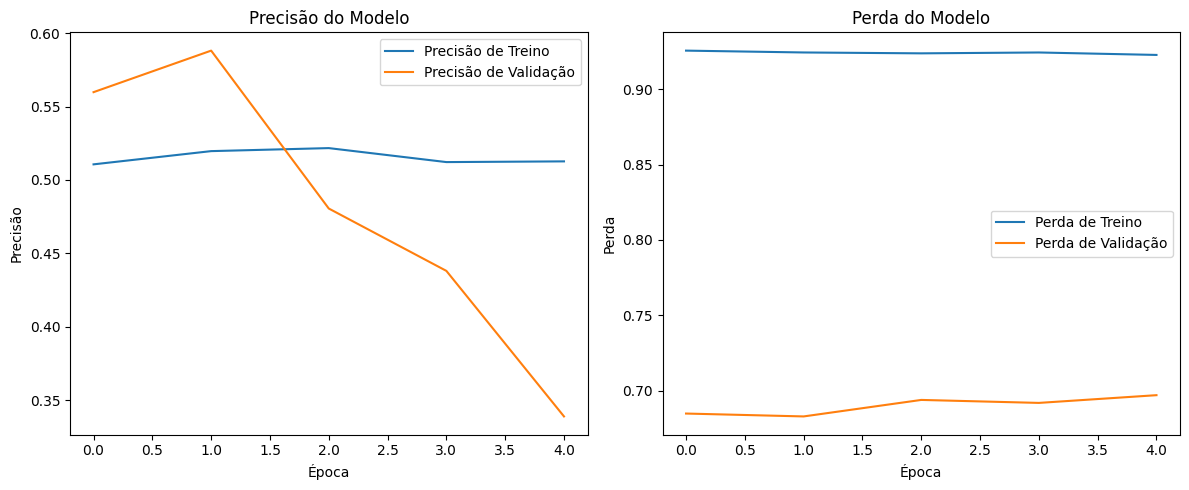


Testando modelo com exemplos de críticas:
Crítica: 'This movie was great!'
Previsto: POSITIVO (Predição: 0.5362)
---
Crítica: 'Absolutely loved it, the acting was superb and the plot kept me engaged throughout the entire film.'
Previsto: POSITIVO (Predição: 0.5362)
---
Crítica: 'Terrible film, waste of time'
Previsto: POSITIVO (Predição: 0.5362)
---
Crítica: 'Boring and predictable'
Previsto: POSITIVO (Predição: 0.5362)
---
Crítica: 'The director's vision shines through in every frame, creating a masterpiece that will be remembered for decades to come.'
Previsto: NEGATIVO (Predição: 0.4638)
---
Crítica: 'Poor character development and a nonsensical plot make this one of the worst films I've seen this year.'
Previsto: POSITIVO (Predição: 0.5362)
---
Crítica: 'OK movie.'
Previsto: NEGATIVO (Predição: 0.4638)
---
Crítica: 'While the cinematography was impressive, the story fell flat and the characters were one-dimensional.'
Previsto: POSITIVO (Predição: 0.5362)
---
Crítica: 'I can't reco

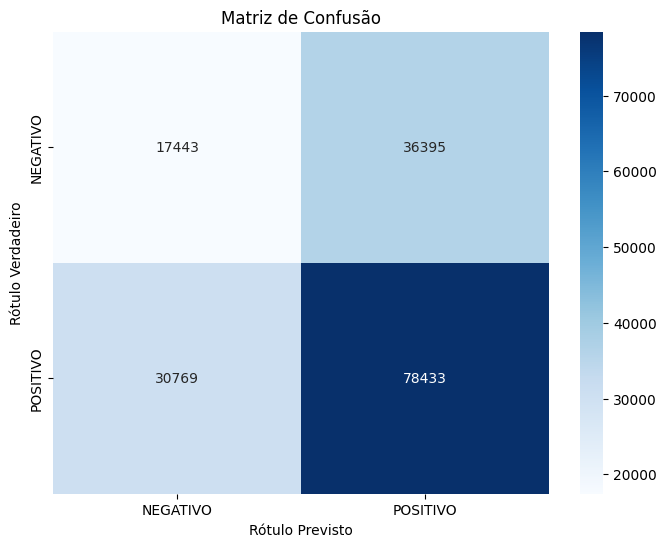


Relatório de Classificação:
              precision    recall  f1-score   support

    NEGATIVO       0.36      0.32      0.34     53838
    POSITIVO       0.68      0.72      0.70    109202

    accuracy                           0.59    163040
   macro avg       0.52      0.52      0.52    163040
weighted avg       0.58      0.59      0.58    163040



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Avaliar desempenho do modelo
loss, accuracy = simple_RNN_model.evaluate(x_test_pad, y_test, verbose=1)
print(f"Perda de Teste: {loss:.4f}")
print(f"Precisão de Teste: {accuracy:.4f}")

# Plotar curvas de aprendizado
import matplotlib.pyplot as plt

# Verificar se o histórico do modelo está disponível e plotar curvas de aprendizado
if hasattr(simple_RNN_model, 'history') and simple_RNN_model.history.history:
    history = simple_RNN_model.history.history
    
    plt.figure(figsize=(12, 5))
    
    # Plotar precisão
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Precisão de Treino')
    plt.plot(history['val_accuracy'], label='Precisão de Validação')
    plt.title('Precisão do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Precisão')
    plt.legend()
    
    # Plotar perda
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Perda de Treino')
    plt.plot(history['val_loss'], label='Perda de Validação')
    plt.title('Perda do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Histórico de treinamento não encontrado.")

# Função para prever sentimento para novas críticas
def predict_sentiment(text):
    # Tokenizar e preencher o texto
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    
    # Fazer previsão
    prediction = simple_RNN_model.predict(padded_sequence, verbose=0)[0][0]
    
    # Interpretar resultado
    sentiment = "POSITIVO" if prediction > 0.5 else "NEGATIVO"
    
    return sentiment, prediction

# Testar com exemplos de críticas
example_reviews = [
    "This movie was great!",
    "Absolutely loved it, the acting was superb and the plot kept me engaged throughout the entire film.",
    "Terrible film, waste of time",
    "Boring and predictable",
    "The director's vision shines through in every frame, creating a masterpiece that will be remembered for decades to come.",
    "Poor character development and a nonsensical plot make this one of the worst films I've seen this year.",
    "OK movie.",
    "While the cinematography was impressive, the story fell flat and the characters were one-dimensional.",
    "I can't recommend this enough - brilliant performances, stunning visuals, and a thought-provoking script.",
    "Disappointing sequel that fails to capture what made the original so special.",
]

print("\nTestando modelo com exemplos de críticas:")
for review in example_reviews:
    sentiment, prob = predict_sentiment(review)
    print(f"Crítica: '{review}'")
    print(f"Previsto: {sentiment} (Predição: {prob:.4f})")
    print("---")

# Criar matriz de confusão
y_pred_prob = simple_RNN_model.predict(x_test_pad, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['NEGATIVO', 'POSITIVO'], yticklabels=['NEGATIVO', 'POSITIVO'])
plt.title('Matriz de Confusão')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['NEGATIVO', 'POSITIVO']))


5095/5095 ━━━━━━━━━━━━━━━━━━━━ 63s 12ms/step - accuracy: 0.8421 - loss: 0.3495
Perda de Teste: 0.3495
Precisão de Teste: 0.8421


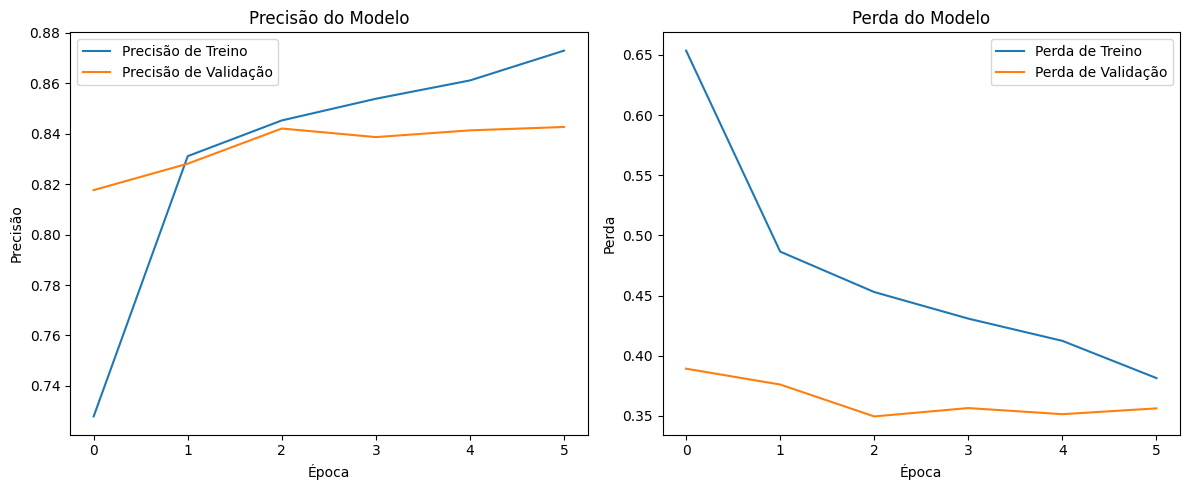


Testando modelo com exemplos de críticas:
Crítica: 'This movie was great!'
Previsto: POSITIVO (Predição: 0.7397)
---
Crítica: 'Absolutely loved it, the acting was superb and the plot kept me engaged throughout the entire film.'
Previsto: POSITIVO (Predição: 0.9937)
---
Crítica: 'Terrible film, waste of time'
Previsto: NEGATIVO (Predição: 0.0077)
---
Crítica: 'Boring and predictable'
Previsto: NEGATIVO (Predição: 0.0076)
---
Crítica: 'The director's vision shines through in every frame, creating a masterpiece that will be remembered for decades to come.'
Previsto: POSITIVO (Predição: 0.9954)
---
Crítica: 'Poor character development and a nonsensical plot make this one of the worst films I've seen this year.'
Previsto: NEGATIVO (Predição: 0.0086)
---
Crítica: 'OK movie.'
Previsto: POSITIVO (Predição: 0.6384)
---
Crítica: 'While the cinematography was impressive, the story fell flat and the characters were one-dimensional.'
Previsto: NEGATIVO (Predição: 0.0492)
---
Crítica: 'I can't reco

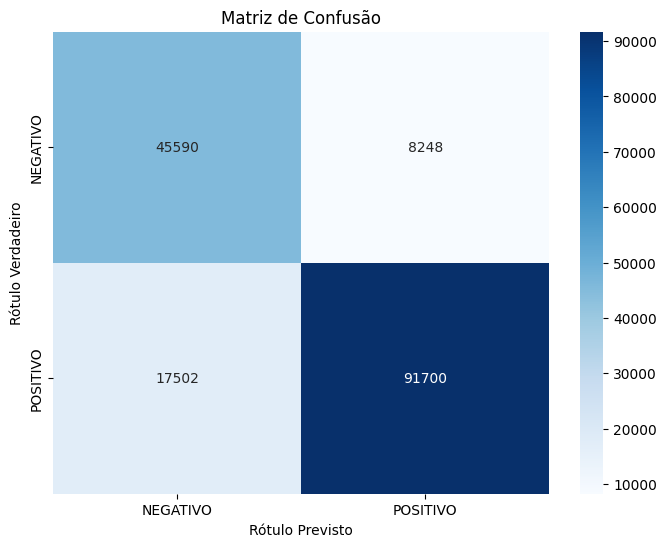


Relatório de Classificação:
              precision    recall  f1-score   support

    NEGATIVO       0.72      0.85      0.78     53838
    POSITIVO       0.92      0.84      0.88    109202

    accuracy                           0.84    163040
   macro avg       0.82      0.84      0.83    163040
weighted avg       0.85      0.84      0.84    163040



In [27]:
# Avaliar desempenho do modelo
loss, accuracy = LSTM_model.evaluate(x_test_pad, y_test, verbose=1)
print(f"Perda de Teste: {loss:.4f}")
print(f"Precisão de Teste: {accuracy:.4f}")

# Verificar se o histórico do modelo está disponível e plotar curvas de aprendizado
if hasattr(LSTM_model, 'history') and LSTM_model.history.history:
    history = LSTM_model.history.history

    plt.figure(figsize=(12, 5))
    
    # Plotar precisão
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Precisão de Treino')
    plt.plot(history['val_accuracy'], label='Precisão de Validação')
    plt.title('Precisão do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Precisão')
    plt.legend()
    
    # Plotar perda
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Perda de Treino')
    plt.plot(history['val_loss'], label='Perda de Validação')
    plt.title('Perda do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Histórico de treinamento não encontrado.")

# Função para prever sentimento para novas críticas
def predict_sentiment(text):
    # Tokenizar e preencher o texto
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    
    # Fazer previsão
    prediction = LSTM_model.predict(padded_sequence, verbose=0)[0][0]

    # Interpretar resultado
    sentiment = "POSITIVO" if prediction > 0.5 else "NEGATIVO"
    
    return sentiment, prediction


print("\nTestando modelo com exemplos de críticas:")
for review in example_reviews:
    sentiment, prob = predict_sentiment(review)
    print(f"Crítica: '{review}'")
    print(f"Previsto: {sentiment} (Predição: {prob:.4f})")
    print("---")

# Criar matriz de confusão
y_pred_prob = LSTM_model.predict(x_test_pad, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['NEGATIVO', 'POSITIVO'], yticklabels=['NEGATIVO', 'POSITIVO'])
plt.title('Matriz de Confusão')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['NEGATIVO', 'POSITIVO']))
